Import libraries and check gpu 

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet, ResNet50
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input,Dense
from tensorflow.python.keras.layers.preprocessing.image_preprocessing import Rescaling, RandomFlip, RandomRotation, RandomContrast, RandomZoom
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import argparse
import cv2
import os

In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Depending on the data set selected run selected cell

# Import dataset 

In [3]:
# train_dir = 'C:\\Users\\natal\\jupyter_notebook\\inzynierka\\FER2013\\train'
# test_dir = 'C:\\Users\\natal\\jupyter_notebook\\inzynierka\\FER2013\\test'

train_dir = 'C:\\Users\\Natalia\\sortech\\Jaffe_ck_custom\\train'
test_dir = 'C:\\Users\\Natalia\\sortech\\Jaffe_ck_custom\\test'
CATEGORIES = os.listdir(test_dir)

cat = []
for ele in CATEGORIES:
    cat.append(str(ele))

    
    
cat

['angry', 'disgusted', 'fear', 'happy', 'neutral', 'sad', 'surprised']

# Plot sample images

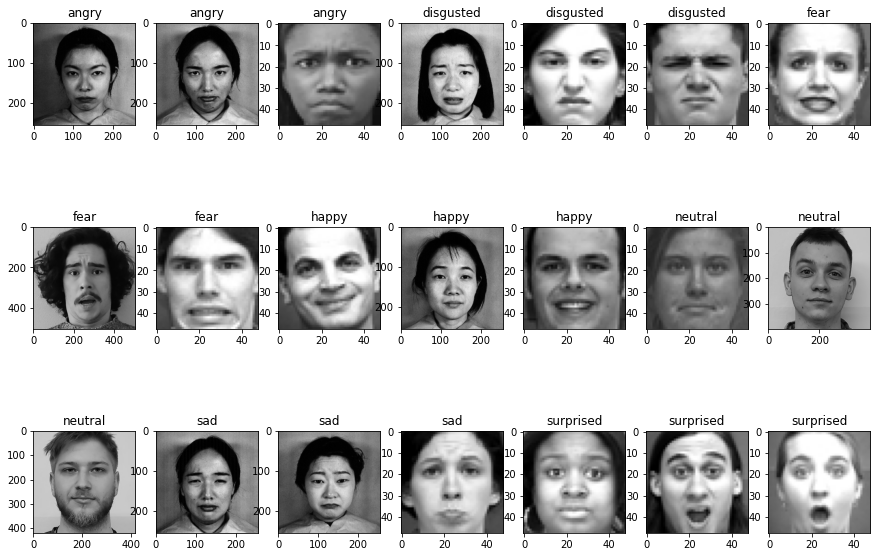

In [4]:
#Visualization of Train Path
def visualize_data(folder):
    c=1
    directory=os.listdir(folder)
    plt.figure(figsize=(15,15))
    for each in directory:
        currentFolder=folder+ "/" +each
        for i, file in enumerate(os.listdir(currentFolder)[2:5]):
            full_path=currentFolder+"/"+file
            plt.subplot(3, 7, c)
            img = cv2.imread(full_path)
            plt.imshow(img)
            plt.title(each)
            c+=1
    plt.subplots_adjust(hspace=-0.5)
    plt.show()
    
visualize_data(test_dir)

Do some pre-processing and data augumentation 

In [5]:
EPOCHS = 60
BATCH_SIZE = 32
DROPOUT_RATE = 0.5
FROZEN_LAYER_NUM = 170

ADAM_LEARNING_RATE = 0.001
SGD_LEARNING_RATE = 0.01
SGD_DECAY = 0.0001

IMG_SIZE = (224, 224)

# Image Data Generator

In [10]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.3,
    color_mode='rgb',
  subset="training",
  label_mode = 'categorical',
    shuffle = True,
  seed=123,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

valid_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.3,
    color_mode='rgb',
  subset="validation",
  label_mode = 'categorical',
     shuffle = True,
  seed=123,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
    color_mode='rgb',
  label_mode = 'categorical',
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)


Found 1133 files belonging to 7 classes.
Using 794 files for training.
Found 1133 files belonging to 7 classes.
Using 339 files for validation.
Found 276 files belonging to 7 classes.


In [11]:
for image_batch, labels_batch in test_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 224, 224, 3)
(32, 7)


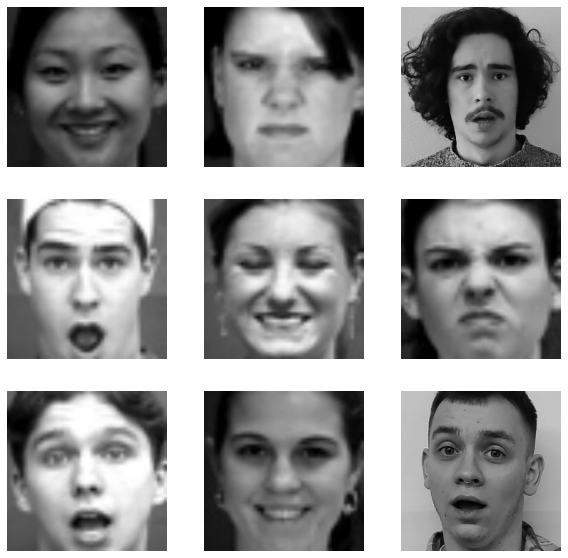

In [12]:
# Plot augmenter images 
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.axis("off")

In [13]:
from tensorflow.keras.applications.mobilenet import preprocess_input
# from tensorflow.keras.applications.vgg16 import preprocess_input
# from tensorflow.keras.applications.resnet50 import preprocess_input
# from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input
# from tensorflow.keras.applications.xception import preprocess_input

# rescale = Rescaling(1./127.5, offset=-1)

rescale = preprocess_input
data_augmentation = tf.keras.Sequential([
  RandomFlip("horizontal_and_vertical"),
  RandomRotation(0.2),
    RandomZoom(0.2),
])

test_gen = test_ds.map(lambda x, y: (rescale(x), y))
valid_gen = valid_ds.map(lambda x, y: (rescale(x), y))
train_gen = train_ds.map(lambda x, y: (rescale(data_augmentation(x)), y))


In [14]:
for image_batch, labels_batch in train_gen:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 224, 224, 3)
(32, 7)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


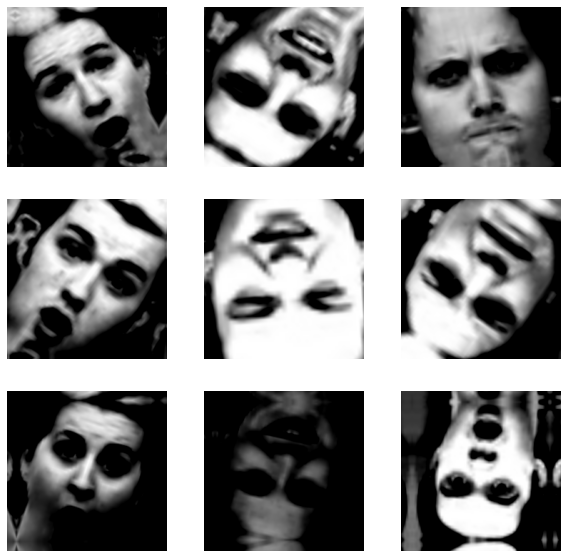

In [15]:
# Plot augmenter images 
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i])
    plt.axis("off")

In [18]:
# check values of pixels 
image_batch, labels_batch = next(iter(train_gen))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

-0.9628244 0.6285434


In [ ]:
# if batch gives error
from pathlib import Path
import imghdr

data_dir = 'C:/Users/Natalia/sortech/JAFFE_CK_split_png/train/new/'
image_extensions = [".png", ".jpg", '.tiff']  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")

In [ ]:
# model1 = tf.keras.Sequential([
#   # Add the preprocessing layers you created earlier.
#   resize_and_rescale,
#   data_augmentation
# ])

In [ ]:
# AUTOTUNE = tf.data.AUTOTUNE

# def prepare(ds, shuffle=False, augment=False):
#     # Resize and rescale all datasets.
#     ds = ds.map(lambda x, y: (rescale(x), y), 
#         num_parallel_calls=AUTOTUNE)

#     if shuffle:
#         ds = ds.shuffle(1000)

#     # Use data augmentation only on the training set.
#     if augment:
#         ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
#             num_parallel_calls=AUTOTUNE)

#     # Use buffered prefetching on all datasets.
#     return ds.prefetch(buffer_size=AUTOTUNE)

# train_ds = prepare(train_ds, shuffle=True, augment=True)
# val_ds = prepare(valid_ds)
# test_ds = prepare(test_ds)

# Pre-trained model 

In [20]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.mobilenet.MobileNet(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')

In [21]:
image_batch, label_batch = next(iter(train_gen))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1024)


In [22]:
base_model.trainable = False
base_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32

To generate predictions from the block of features, average over the spatial 5x5 spatial locations, using a tf.keras.layers.GlobalAveragePooling2D layer to convert the features to a single 1280-element vector per image. It is like GlobalAveragePooling2D applies average pooling on the spatial dimensions until each spatial dimension is one.

In [23]:
# # When you define the model, you need to tell Keras how to map inputs to outputs, in our scenario, 
# # inputs -> data augmentation layer -> preprocess (rescale) layer -> MobileV2Net -> GlobalAveragePooling2D layer -> Dropout layer -> Dense layer.

headModel = base_model.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)

# 128 refers to the neurons in the hidden layer
headModel = Dense(128, activation="relu")(headModel)

# 0.5 refers to the fraction of the input that is dropped
headModel = Dropout(0.5)(headModel)

# 2 refers to the neurons in the output layer
headModel = Dense(7, activation="softmax")(headModel)
# ------------------------------------------------------
# avgPool = AveragePooling2D(pool_size=(7, 7))
# flatten = Flatten(name="flatten")

# # 128 refers to the neurons in the hidden layer
# dense1 = Dense(128, activation="relu")

# # 0.5 refers to the fraction of the input that is dropped
# drop = Dropout(0.5)

# # 2 refers to the neurons in the output layer
# dense2 = Dense(7, activation="softmax")

In [24]:
model = Model(inputs=base_model.input, outputs=headModel)

Plot model

In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=150,
    layer_range=None,
    show_layer_activations=True
)

In [25]:
optim = tf.keras.optimizers.Adam(learning_rate=ADAM_LEARNING_RATE, epsilon=1e-08, decay=0.0)
sgd = tf.keras.optimizers.SGD(learning_rate=SGD_LEARNING_RATE, momentum=0.9, decay=SGD_DECAY, nesterov=True)
rlrop = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',mode='min',factor=0.5, patience=10, min_lr=0.00001, verbose=1)
csvlogger = tf.keras.callbacks.CSVLogger('log_mobilenet_cust.csv')
tb = tf.keras.callbacks.TensorBoard(log_dir='./logs_mobilenet_cust')

callbacks = [ rlrop,
             csvlogger,
             tb       ]

In [26]:
model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['accuracy'])

In [27]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0     

In [28]:
# train
history = model.fit(
    train_gen,
    validation_data=valid_gen, 
    shuffle=True,
    epochs=EPOCHS,
    callbacks=callbacks
) 

Epoch 1/60
25/25 [==============================] - 15s 492ms/step - loss: 2.0741 - accuracy: 0.2406 - val_loss: 1.7260 - val_accuracy: 0.3599
Epoch 2/60
25/25 [==============================] - 10s 394ms/step - loss: 1.7020 - accuracy: 0.3615 - val_loss: 1.5752 - val_accuracy: 0.5015
Epoch 3/60
25/25 [==============================] - 10s 379ms/step - loss: 1.5899 - accuracy: 0.4181 - val_loss: 1.5725 - val_accuracy: 0.3186
Epoch 4/60
25/25 [==============================] - 10s 391ms/step - loss: 1.5184 - accuracy: 0.4270 - val_loss: 1.4359 - val_accuracy: 0.4985
Epoch 5/60
25/25 [==============================] - 10s 388ms/step - loss: 1.4057 - accuracy: 0.4937 - val_loss: 1.3963 - val_accuracy: 0.4926
Epoch 6/60
25/25 [==============================] - 10s 408ms/step - loss: 1.3379 - accuracy: 0.4861 - val_loss: 1.2613 - val_accuracy: 0.5457
Epoch 7/60
25/25 [==============================] - 11s 424ms/step - loss: 1.2928 - accuracy: 0.5176 - val_loss: 1.2085 - val_accuracy: 0.6047

In [ ]:
os.chdir('/tf/notebooks/Natalia/CK/models/mobilenet/')

In [ ]:
# model.save('model_vgg16_fer_100ep_1.h5') #save model

In [41]:
json_string = model.to_json()
json_string 

'{"class_name": "Functional", "config": {"name": "model", "layers": [{"class_name": "InputLayer", "config": {"batch_input_shape": [null, 224, 224, 3], "dtype": "float32", "sparse": false, "ragged": false, "name": "input_1"}, "name": "input_1", "inbound_nodes": []}, {"class_name": "Conv2D", "config": {"name": "conv1", "trainable": false, "dtype": "float32", "filters": 32, "kernel_size": [3, 3], "strides": [2, 2], "padding": "same", "data_format": "channels_last", "dilation_rate": [1, 1], "groups": 1, "activation": "linear", "use_bias": false, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}, "name": "conv1", "inbound_nodes": [[["input_1", 0, 0, {}]]]}, {"class_name": "BatchNormalization", "config": {"name": "conv1_bn", "trainable": false, "dtype": "float32", "axis

In [29]:
# evaluate model 
# train_evalation = model.evaluate(train_generator)
test_evaluation = model.evaluate(test_gen)

9/9 [==============================] - 2s 125ms/step - loss: 0.8235 - accuracy: 0.6957


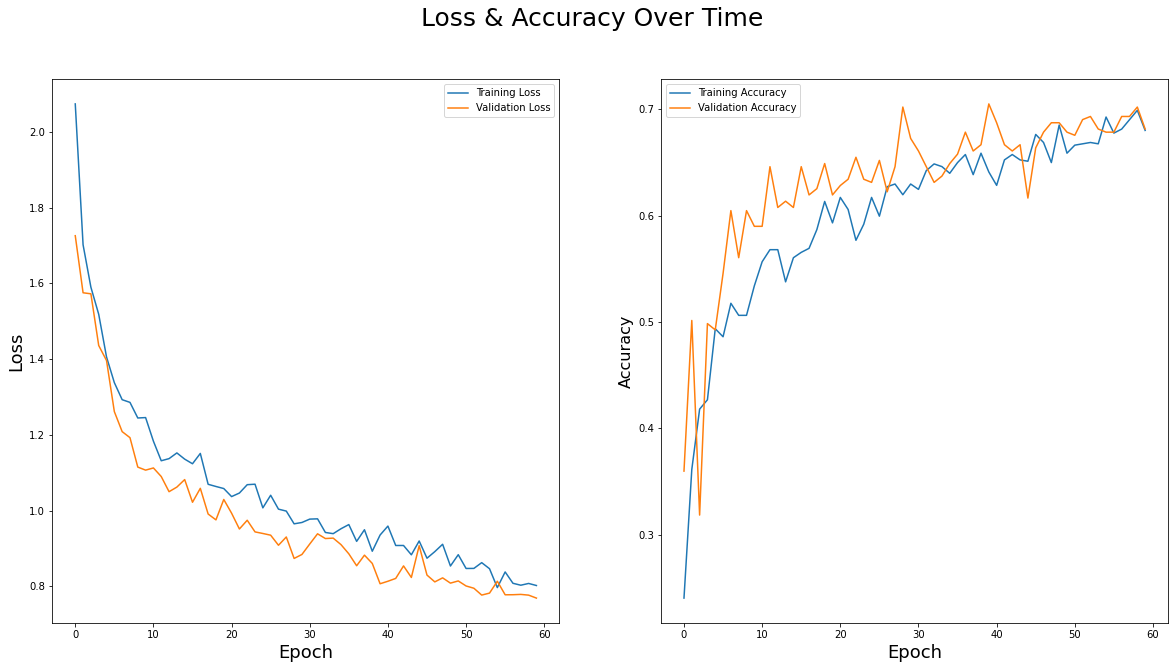

In [30]:
# plot metrics

plt.figure(figsize=(20,10))
plt.suptitle('Loss & Accuracy Over Time', fontsize=25)

plt.subplot(1, 2, 1)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='upper left')
plt.show()


In [ ]:
history.history['accuracy']

In [31]:
test_ds = test_ds.unbatch()

In [32]:
y = np.concatenate([y for x, y in test_gen], axis=0)

In [33]:
y_ = np.argmax(y, axis=1)

In [34]:
y_

array([4, 2, 2, 3, 0, 1, 1, 2, 3, 6, 1, 4, 2, 6, 3, 2, 3, 3, 6, 6, 1, 3,
       1, 3, 3, 2, 0, 1, 6, 1, 5, 6, 6, 6, 4, 3, 2, 1, 1, 3, 1, 4, 3, 3,
       6, 5, 3, 1, 3, 2, 6, 6, 0, 3, 6, 3, 1, 4, 5, 1, 0, 3, 6, 3, 0, 1,
       6, 6, 6, 6, 4, 1, 6, 0, 4, 0, 1, 3, 6, 0, 0, 0, 0, 0, 2, 3, 0, 3,
       5, 6, 5, 3, 5, 3, 2, 3, 6, 0, 1, 0, 1, 3, 3, 6, 6, 6, 1, 6, 0, 3,
       4, 6, 3, 3, 4, 6, 4, 0, 6, 6, 0, 6, 3, 0, 2, 5, 3, 1, 6, 4, 3, 1,
       6, 3, 0, 5, 6, 5, 1, 1, 4, 6, 0, 6, 6, 1, 4, 3, 6, 6, 2, 6, 6, 3,
       3, 2, 6, 4, 1, 5, 0, 5, 5, 1, 1, 3, 3, 4, 2, 0, 3, 5, 1, 1, 3, 3,
       6, 3, 0, 3, 5, 1, 1, 1, 6, 4, 5, 6, 3, 2, 3, 2, 1, 5, 4, 0, 6, 0,
       1, 6, 1, 4, 5, 4, 3, 3, 3, 5, 0, 5, 1, 3, 0, 0, 1, 0, 0, 6, 6, 5,
       0, 6, 1, 5, 1, 6, 2, 3, 3, 4, 0, 2, 6, 6, 1, 4, 0, 1, 3, 2, 4, 2,
       2, 1, 0, 5, 1, 6, 5, 2, 3, 3, 2, 1, 2, 3, 6, 0, 5, 3, 3, 2, 6, 6,
       5, 2, 3, 0, 1, 6, 2, 6, 5, 3, 1, 4], dtype=int64)

In [35]:
Y_pred = model.predict(test_gen, )
y_pred = np.argmax(Y_pred, axis=1)
y_pred

array([1, 5, 3, 4, 6, 2, 6, 2, 1, 2, 0, 5, 0, 0, 5, 6, 3, 3, 6, 0, 2, 6,
       6, 3, 2, 0, 5, 1, 2, 4, 3, 1, 2, 2, 3, 1, 3, 1, 4, 0, 5, 4, 0, 4,
       6, 2, 1, 3, 1, 1, 4, 3, 3, 2, 1, 2, 6, 1, 6, 5, 6, 1, 5, 2, 3, 3,
       2, 4, 5, 3, 5, 4, 1, 2, 6, 3, 4, 1, 0, 1, 6, 2, 1, 0, 3, 5, 6, 6,
       2, 0, 2, 1, 4, 3, 3, 1, 0, 5, 5, 1, 6, 6, 1, 0, 5, 2, 5, 4, 3, 1,
       1, 6, 5, 6, 6, 6, 5, 3, 6, 1, 3, 0, 3, 3, 3, 5, 0, 0, 1, 3, 1, 3,
       0, 0, 6, 1, 6, 6, 3, 6, 5, 6, 0, 5, 1, 2, 2, 3, 5, 6, 2, 6, 2, 6,
       5, 0, 5, 1, 2, 0, 0, 3, 3, 1, 6, 0, 0, 1, 6, 3, 2, 1, 3, 1, 3, 6,
       2, 1, 6, 3, 3, 3, 1, 0, 6, 5, 2, 0, 6, 0, 6, 1, 6, 1, 4, 6, 0, 6,
       4, 6, 3, 1, 3, 6, 3, 6, 0, 3, 6, 3, 1, 1, 3, 0, 5, 3, 6, 3, 2, 2,
       3, 0, 5, 0, 2, 1, 1, 4, 3, 4, 3, 2, 0, 3, 5, 4, 2, 3, 3, 4, 6, 3,
       6, 1, 3, 6, 2, 0, 0, 3, 3, 6, 5, 6, 1, 6, 5, 3, 3, 3, 6, 6, 4, 3,
       5, 0, 4, 1, 0, 1, 0, 2, 0, 0, 0, 3], dtype=int64)

In [36]:
target_names = cat

In [37]:
# Confution Matrix and Classification Report
from sklearn.metrics import confusion_matrix

from sklearn.metrics import plot_confusion_matrix, ConfusionMatrixDisplay

Y_pred = model.predict(test_gen, )
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(y_, y_pred))
print('Classification Report')
print(classification_report(y_, y_pred, target_names=target_names, zero_division=0))

Confusion Matrix
[[ 7  3  4  4  4  4 11]
 [ 8 11  4 11  2  5  5]
 [ 3  6  4  6  2  3  3]
 [ 5 10  9 13  6  6 10]
 [ 6  3  5  2  0  3  4]
 [ 2  4  1 10  1  3  5]
 [ 9  8  6 12  4  5 14]]
Classification Report
              precision    recall  f1-score   support

       angry       0.17      0.19      0.18        37
   disgusted       0.24      0.24      0.24        46
        fear       0.12      0.15      0.13        27
       happy       0.22      0.22      0.22        59
     neutral       0.00      0.00      0.00        23
         sad       0.10      0.12      0.11        26
   surprised       0.27      0.24      0.25        58

    accuracy                           0.19       276
   macro avg       0.16      0.16      0.16       276
weighted avg       0.19      0.19      0.19       276



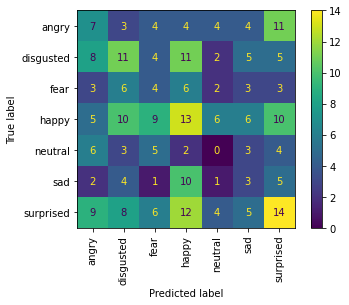

In [38]:
# plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_, y_pred), display_labels=target_names)
disp.plot(xticks_rotation='vertical')
plt.show()

In [ ]:
test_evaluation[1]

In [40]:
epoch_str = '-EPOCHS_' + str(EPOCHS)
test_acc = 'test_acc_%.3f' % test_evaluation[1]
model.save('ck_jaffe_custom_mobilenet-' + epoch_str + test_acc +'.h5')

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [ ]:
model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
len(model.trainable_variables)

In [ ]:
fine_tune_epochs = 10
total_epochs =  EPOCHS + fine_tune_epochs

history_fine = model.fit(train_gen,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    validation_data=valid_gen, 
    shuffle=True,
    callbacks=callbacks
) 

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(2, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([EPOCHS-1,EPOCHS-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([EPOCHS-1,EPOCHS-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
epoch_str = '-EPOCHS_' + str(EPOCHS)
test_acc = 'test_acc_%.3f' % test_evaluation[1]
model.save('ck_jaffe_mobilenetV2_tuning' + epoch_str + test_acc +'.h5')